# Importing Libraries

In [1]:
import os
import random
import argparse
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torch.amp import autocast, GradScaler

# Configuration & Utilities

In [10]:
def set_seed(seed: int = 42):
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class Config:
    """Configuration class for model and training hyperparameters."""
    def __init__(self):
        self.num_samples = 20000
        self.seq_len = 12
        self.vocab_size = 50  # Base vocabulary size
        self.embed_size = 128
        self.hidden_size = 256
        self.enc_layers = 2
        self.dec_layers = 2
        self.dropout = 0.25
        self.batch_size = 128
        self.epochs = 20
        self.lr = 1e-3
        self.clip = 1.0
        self.train_split = 0.8
        self.seed = 42
        self.log_dir = 'runs/best_seq2seq'
        self.checkpoint_dir = 'checkpoints'

        # Special Tokens
        self.PAD_IDX = 0
        self.BOS_IDX = 1
        self.EOS_IDX = 2

        # Adjust vocab size to include special tokens
        self.effective_vocab_size = self.vocab_size + 3

# Dataset Generation

In [11]:
class ReverseDataset(Dataset):
    """
    A dataset that generates sequences and their reversed counterparts on the fly.
    This is memory-efficient as it doesn't store all samples in memory.
    """
    def __init__(self, num_samples, seq_len, vocab_size, bos_idx):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.bos_idx = bos_idx

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate a random sequence of integers. Start from 3 to avoid special tokens.
        src = torch.randint(3, self.vocab_size, (self.seq_len,), dtype=torch.long)

        # The target is the reversed source, prefixed with a BOS token.
        trg = torch.cat([torch.tensor([self.bos_idx]), src.flip(dims=[0])], dim=0)
        return src, trg

def create_collate_fn(pad_idx):
    """
    Creates a collate function to pad sequences for batching.
    Using pad_sequence is much more efficient than manual padding.
    """
    def collate_fn(batch):
        src_batch, trg_batch = zip(*batch)

        # Get the length of each source sequence for packing later
        src_lengths = torch.tensor([len(s) for s in src_batch], dtype=torch.long)

        # Pad the sequences
        src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_idx)
        trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=pad_idx)

        return src_padded, trg_padded, src_lengths
    return collate_fn

# Model Architecture

In [12]:
class Encoder(nn.Module):
    """The Encoder part of the Seq2Seq model."""
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.1, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(
            embed_size, hidden_size, num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size

    def forward(self, src, lengths):
        """
        Forward pass of the encoder.
        Uses packing to efficiently process variable-length sequences.
        """
        embedded = self.embedding(src)
        # Pack padded sequence to ignore padding in RNN computation
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.gru(packed)
        # Unpack sequence
        outputs, _ = pad_packed_sequence(outputs, batch_first=True, total_length=src.size(1))

        return outputs, hidden

class Attention(nn.Module):
    """The Attention mechanism."""
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Attention linear layer
        self.attn = nn.Linear((enc_hidden_size * 2) + dec_hidden_size, dec_hidden_size)
        self.v = nn.Parameter(torch.rand(dec_hidden_size))

    def forward(self, hidden, encoder_outputs, mask):
        seq_len = encoder_outputs.size(1)
        # Repeat decoder hidden state seq_len times
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.permute(0, 2, 1)

        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)

        # Calculate attention weights
        weights = torch.bmm(v, energy).squeeze(1)

        # CORRECTED LINE: Use a smaller value for masking that is float16-safe.
        weights = weights.masked_fill(mask == 0, -1e4)

        return torch.softmax(weights, dim=1)

class Decoder(nn.Module):
    """The Decoder part of the Seq2Seq model."""
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, attention, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = attention
        self.gru = nn.GRU(
            (enc_hidden_size * 2) + embed_size, dec_hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.fc_out = nn.Linear((enc_hidden_size * 2) + dec_hidden_size + embed_size, vocab_size)

    def forward(self, input_step, hidden, encoder_outputs, mask):
        embedded = self.embedding(input_step).unsqueeze(1) # [B, 1, emb_dim]

        # Use the last hidden state of the top layer for attention
        dec_hidden_for_attn = hidden[-1]

        # Get attention weights and context vector
        attn_weights = self.attention(dec_hidden_for_attn, encoder_outputs, mask).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)

        # Concatenate embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(rnn_input, hidden)

        # Concatenate all vectors for the final prediction
        pred_input = torch.cat((output, context, embedded), dim=2).squeeze(1)
        prediction = self.fc_out(pred_input)

        return prediction, hidden

class Seq2Seq(nn.Module):
    """The main Seq2Seq model wrapper."""
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.config = config

        enc_hidden_size = config.hidden_size
        dec_hidden_size = config.hidden_size * 2 # To match bidirectional encoder

        self.encoder = Encoder(config.effective_vocab_size, config.embed_size, enc_hidden_size,
                               config.enc_layers, config.dropout, bidirectional=True)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.decoder = Decoder(config.effective_vocab_size, config.embed_size, enc_hidden_size,
                               dec_hidden_size, self.attention, config.dec_layers, config.dropout)

        # Bridge layer to match encoder and decoder hidden state dimensions and directions
        self.bridge = nn.Linear(enc_hidden_size * 2, dec_hidden_size)

    def create_mask(self, lengths, max_len):
        """Creates a mask for the source sequence to ignore padding in attention."""
        batch_size = lengths.size(0)
        mask = torch.arange(max_len, device=self.device).expand(batch_size, max_len)
        return mask < lengths.unsqueeze(1)

    def forward(self, src, trg, lengths, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape
        vocab_size = self.config.effective_vocab_size

        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)

        encoder_outputs, hidden = self.encoder(src, lengths)

        # Adapt encoder's bidirectional hidden state for the decoder
        # Concatenate forward and backward hidden states from all layers
        hidden = hidden.view(self.config.enc_layers, 2, batch_size, -1)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)

        # The first input to the decoder is the <BOS> token
        input_step = trg[:, 0]

        # Create attention mask
        mask = self.create_mask(lengths, src.size(1))

        for t in range(1, trg_len):
            output, hidden = self.decoder(input_step, hidden, encoder_outputs, mask)
            outputs[:, t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input_step = trg[:, t] if teacher_force else top1

        return outputs

# Traning & Evaluating

In [13]:
def train_epoch(model, dataloader, optimizer, criterion, clip, scaler):
    """Trains the model for one epoch."""
    model.train()
    epoch_loss = 0

    for src, trg, lengths in tqdm(dataloader, desc="Training", leave=False):
        # Move all tensors to the correct device
        src, trg, lengths = src.to(model.device), trg.to(model.device), lengths.to(model.device)

        optimizer.zero_grad()

        # Use mixed-precision training for efficiency
        with autocast(device_type=model.device.type):
            output = model(src, trg, lengths)
            output_dim = output.shape[-1]
            # Ignore <BOS> token in loss calculation
            out = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(out, trg_flat)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer) # Unscale before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate_epoch(model, dataloader, criterion):
    """Evaluates the model for one epoch."""
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for src, trg, lengths in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move all tensors to the correct device
            src, trg, lengths = src.to(model.device), trg.to(model.device), lengths.to(model.device)

            # Turn off teacher forcing for evaluation
            output = model(src, trg, lengths, teacher_forcing_ratio=0.0)

            output_dim = output.shape[-1]
            out = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)

            loss = criterion(out, trg_flat)
            epoch_loss += loss.item()

            preds = output.argmax(2)
            # Check for exact sequence match, ignoring <BOS>
            correct += (preds[:, 1:] == trg[:, 1:]).all(dim=1).sum().item()
            total += src.size(0)

    return epoch_loss / len(dataloader), correct / total

# Main Runner

🚀 Starting Training...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 1.4830 | Val Loss: 0.0867 | Val Acc: 91.55%
✅ New best model saved at epoch 1


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.3467 | Val Loss: 0.0186 | Val Acc: 98.70%
✅ New best model saved at epoch 2


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.0347 | Val Loss: 0.0467 | Val Acc: 98.12%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.0259 | Val Loss: 0.0210 | Val Acc: 98.75%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.0241 | Val Loss: 0.0804 | Val Acc: 96.08%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.0140 | Val Loss: 0.0009 | Val Acc: 99.95%
✅ New best model saved at epoch 6


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.0177 | Val Loss: 0.0183 | Val Acc: 99.08%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.0122 | Val Loss: 0.0156 | Val Acc: 98.38%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.0264 | Val Loss: 0.0225 | Val Acc: 98.78%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0238 | Val Loss: 0.0116 | Val Acc: 99.22%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.0085 | Val Loss: 0.0121 | Val Acc: 99.30%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.0121 | Val Loss: 0.0026 | Val Acc: 99.90%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.0011 | Val Loss: 0.0145 | Val Acc: 99.35%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.0237 | Val Loss: 0.0128 | Val Acc: 99.15%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.0114 | Val Loss: 0.0147 | Val Acc: 99.02%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.0130 | Val Loss: 0.0159 | Val Acc: 98.70%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.0042 | Val Loss: 0.0084 | Val Acc: 99.65%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.0016 | Val Loss: 0.0003 | Val Acc: 99.92%
✅ New best model saved at epoch 18


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.0119 | Val Loss: 0.0361 | Val Acc: 97.22%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.0154 | Val Loss: 0.0075 | Val Acc: 99.30%
✅ Training complete.


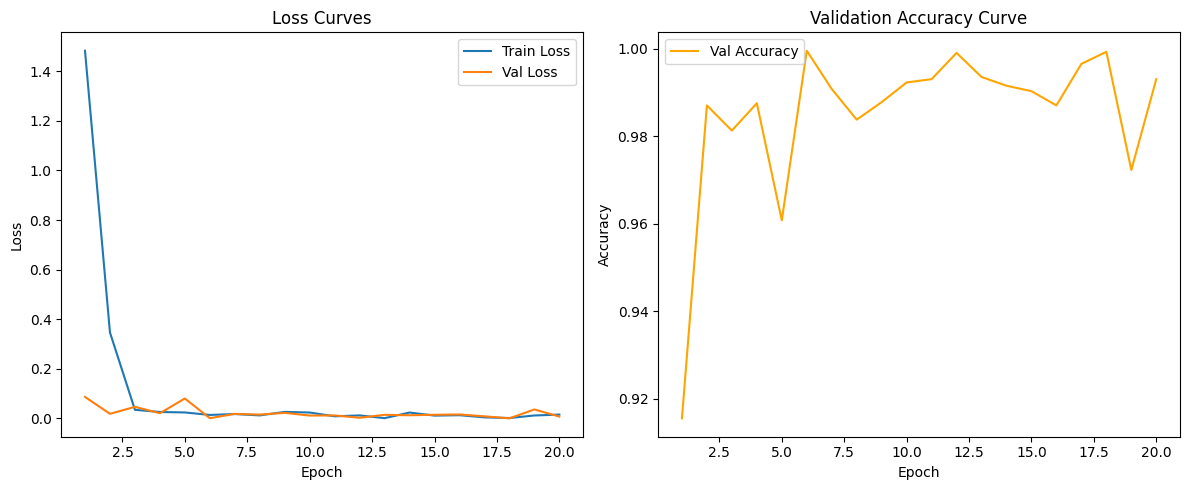

In [14]:
def main():
    """Main function to run the training and evaluation process."""
    config = Config()
    set_seed(config.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create DataLoaders
    train_samples = int(config.num_samples * config.train_split)
    val_samples = config.num_samples - train_samples

    collate_fn = create_collate_fn(config.PAD_IDX)

    train_ds = ReverseDataset(train_samples, config.seq_len, config.vocab_size, config.BOS_IDX)
    val_ds = ReverseDataset(val_samples, config.seq_len, config.vocab_size, config.BOS_IDX)

    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, optimizer, and criterion
    model = Seq2Seq(config, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=config.PAD_IDX)

    # GradScaler for mixed-precision
    scaler = GradScaler(enabled=torch.cuda.is_available())

    # Setup for logging and saving
    writer = SummaryWriter(log_dir=config.log_dir)
    Path(config.checkpoint_dir).mkdir(parents=True, exist_ok=True)
    best_val_loss = float('inf')

    train_losses, val_losses, val_accs = [], [], []

    print("🚀 Starting Training...")
    for epoch in range(1, config.epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, config.clip, scaler)
        val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Log to TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), Path(config.checkpoint_dir) / 'best_model.pt')
            print(f"✅ New best model saved at epoch {epoch}")

    writer.close()
    print("✅ Training complete.")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, config.epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, config.epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, config.epochs + 1), val_accs, label='Val Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()